In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats
import matplotlib.mlab as mlab

In [2]:
data = pd.read_csv('Downloads/data20180918n.txt', sep=",")

In [3]:
data.head()

,RTICIDNEW,LEN,FUNCLASS,UPDATE_TIME,SPEED
0,46607520302,327.36906,4,201809180001,53.5090909090909
1,46607520302,327.36906,4,201809180002,56.0571428571429
2,46607520302,327.36906,4,201809180004,56.0571428571429
3,46607520302,327.36906,4,201809180005,56.0571428571429
4,46607520302,327.36906,4,201809180007,49.05


## 数据清洗

1. 检查 None value  
2. 数据查重
3. 数据标准化
4. 数据错误检查

In [4]:
data.describe()

,RTICIDNEW,LEN,FUNCLASS
count,1.268549e+06,1.268549e+06,1.268549e+06
mean,4.674437e+10,3.600805e+02,4.467695e+00
std,3.423383e+08,3.160043e+02,1.099981e+00
min,4.660742e+10,1.187399e+00,2.000000e+00
25%,4.660743e+10,1.306022e+02,4.000000e+00
50%,4.660747e+10,2.830025e+02,4.000000e+00
75%,4.660754e+10,4.950588e+02,5.000000e+00
max,4.760057e+10,2.092054e+03,7.000000e+00


由于describe 没有speed 数据，说明UPDATE_TIME, SPEED 是str，进行标准化 SPEED 变成int

In [5]:
speed = []
for each in data.SPEED:
    try:
        val = round(float(each), 2)
    except:
        val = np.nan
    speed.append(val)
data.SPEED = speed

In [6]:
time = []
for each in data.UPDATE_TIME:
    try:
        val = str(each)
    except:
        val = np.nan
    time.append(val)
data.UPDATE_TIME = time

In [7]:
df_na = data[data.isnull().any(axis=1)]
rat = round(len(df_na)/len(data)*100,4)
print("共有" + str(len(df_na)) + "行数据是空值")
print('空值百分比'+ str(rat) + "%")
df_na.head()

共有273行数据是空值
空值百分比0.0215%


,RTICIDNEW,LEN,FUNCLASS,UPDATE_TIME,SPEED
1774,47600561246,166.777730,6,\N,NaN
1775,47600561493,566.345457,6,\N,NaN
1776,47600561449,566.345457,6,\N,NaN
1777,47600561337,166.777730,6,\N,NaN
2573,46607550016,91.182013,4,\N,NaN


由于空值百分比0.0215%, 可以直接舍去

In [8]:
data = data.dropna()
data = data.reset_index(drop = True)
data[data.isnull().any(axis=1)]

,RTICIDNEW,LEN,FUNCLASS,UPDATE_TIME,SPEED


In [9]:
data.describe()

,RTICIDNEW,LEN,FUNCLASS,SPEED
count,1.268276e+06,1.268276e+06,1.268276e+06,1.268276e+06
mean,4.674433e+10,3.601079e+02,4.467490e+00,3.947367e+01
std,3.422977e+08,3.160071e+02,1.099915e+00,1.483424e+01
min,4.660742e+10,1.187399e+00,2.000000e+00,1.500000e+00
25%,4.660743e+10,1.306022e+02,4.000000e+00,2.880000e+01
50%,4.660747e+10,2.830025e+02,4.000000e+00,3.658000e+01
75%,4.660754e+10,4.950588e+02,5.000000e+00,4.942000e+01
max,4.760057e+10,2.092054e+03,7.000000e+00,1.224000e+02


In [10]:
## 检查时间范围
time_rang = [each for each in data.UPDATE_TIME]
min_time = min(time_rang)
max_time = max(time_rang)
#time_rang = ','.join(time_rang)
print("该份报告包含以下时间范围: ", min_time, "到",  max_time)

该份报告包含以下时间范围:  201809180001 到 201809182358


In [11]:
## 检查异常值,是否有大于 59 分的数据出现
error_time = [each for each in data.UPDATE_TIME if int(each[-2:]) > 59 or int(each[-4:-2]) > 23]
error_time = ','.join(error_time)
print("该份报告包含以下错误时间: ", error_time)

该份报告包含以下错误时间:  


该份报告时间从 2018/09/18/00:01 到 2018/09/18/23:58

In [12]:
data.head()

,RTICIDNEW,LEN,FUNCLASS,UPDATE_TIME,SPEED
0,46607520302,327.36906,4,201809180001,53.51
1,46607520302,327.36906,4,201809180002,56.06
2,46607520302,327.36906,4,201809180004,56.06
3,46607520302,327.36906,4,201809180005,56.06
4,46607520302,327.36906,4,201809180007,49.05


In [13]:
len(data.RTICIDNEW.unique()), len(data.LEN.unique()) # 路程种类和路段种类不匹配，可能存在错误

(1653, 1548)

In [14]:
# 检查相同路段不同路程，或者相同路程，路段编号不同
diff = [(data.RTICIDNEW[i+1],data.LEN[i+1]) for i in range(len(data)-1) if data.RTICIDNEW[i+1] != data.RTICIDNEW[i] or\
 data.LEN[i+1] != data.LEN[i]]

In [15]:
len(diff)

1732

In [16]:
# 如果道路长度一致，说明同一条道路，考虑到正反车道可能，一条道路的车速不

sam_rd = []
for i in range(len(diff)-1):
    if diff[i+1][0] == diff[i][0] or diff[i+1][1] == diff[i][1]:
        sam_rd.append((diff[i+1], diff[i]))
print('相同车道列表如下:')
sam_rd

相同车道列表如下:


[((46607561891, 45.413881565112106), (46607561859, 45.413881565112106)),
 ((46607540862, 42.7264680039657), (46607540863, 42.7264680039657)),
 ((47600560604, 22.957282787653604), (47600561005, 22.957282787653604)),
 ((47600560603, 107.391259862852), (47600561003, 107.391259862852)),
 ((47600570035, 652.011771210752), (47600570010, 652.011771210752)),
 ((46607460269, 11.107664934790401), (46607460978, 11.107664934790401)),
 ((46607561039, 198.268536817261), (46607560467, 198.268536817261)),
 ((46607460273, 35.8543979930116), (46607460986, 35.8543979930116)),
 ((46607570033, 86.80321047677342), (46607570096, 86.80321047677342)),
 ((46607460774, 318.76261325852903), (46607461385, 318.76261325852903)),
 ((46607540310, 674.008050047304), (46607540315, 674.008050047304)),
 ((46607460334, 202.93319083994098), (46607461044, 202.93319083994098)),
 ((46607540693, 555.038464667859), (46607540696, 555.038464667859)),
 ((46607570205, 279.910352507745), (46607570213, 279.910352507745)),
 ((466074403

In [17]:
road_same = []
for each in sam_rd:
    df_r1 = data[data.RTICIDNEW == each[0][0]].reset_index(drop = True)
    df_r2 = data[data.RTICIDNEW == each[1][0]].reset_index(drop = True)
    if len(df_r1) == len(df_r2):
        if df_r1[['LEN', 'FUNCLASS', 'UPDATE_TIME', 'SPEED']] == df_r2[['LEN', 'FUNCLASS', 'UPDATE_TIME', 'SPEED']]:
            road_same.append(each[0])
print('完全相同的路段: ')
print(road_same)

完全相同的路段: 
[]


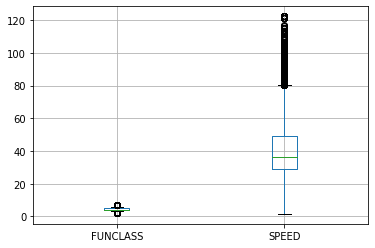

In [14]:
# boxplot 去分析是否存在个别错误数据
data.boxplot(column=['FUNCLASS', 'SPEED'])# 可以看到速度最高过了120，可能存在错误或超速情况

In [15]:
data[data.SPEED >= 120] # 属于合理范围

,RTICIDNEW,LEN,FUNCLASS,UPDATE_TIME,SPEED
320363,46607430295,133.111974,5,201809180249,121.5
320364,46607430295,133.111974,5,201809180250,121.5
320365,46607430295,133.111974,5,201809180252,121.5
320366,46607430295,133.111974,5,201809180253,121.5
320367,46607430295,133.111974,5,201809180255,121.5
320368,46607430295,133.111974,5,201809180256,121.5
320369,46607430295,133.111974,5,201809180258,121.5
320370,46607430295,133.111974,5,201809180259,121.5
320371,46607430295,133.111974,5,201809180301,121.5
393831,46607520280,13.562929,3,201809180713,122.4


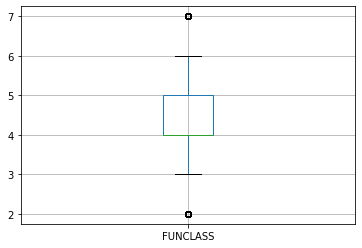

In [16]:
data.boxplot(column=['FUNCLASS']) # funclass 从2-7 属于合理范围，尽管他们并不是数据的正常值

In [17]:
# 由于我们知道 data和 RTICIDNEW 关系不大，删了
data = data[['LEN', 'FUNCLASS', 'UPDATE_TIME', 'SPEED']]

/Users/wilson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]


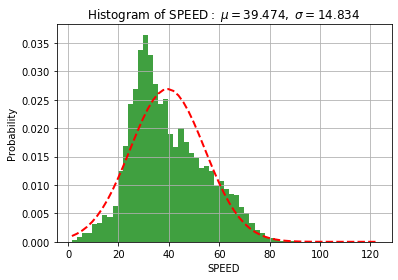

In [23]:
# 分析全天速度分布是否遵从正态分布
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# read data from a text file. One number per line
datos = list(data.SPEED)

# best fit of data
(mu, sigma) = norm.fit(datos)

# the histogram of the data
n, bins, patches = plt.hist(datos, 60, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = scipy.stats.norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('SPEED')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ SPEED:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()


In [24]:
# 每小时的平均时速
alist = list(data.UPDATE_TIME)
for i in range(len(alist)):
    alist[i] = alist[i][-4:-2]
data.UPDATE_TIME = alist
data.head()

,LEN,FUNCLASS,UPDATE_TIME,SPEED
0,327.36906,4,00,53.51
1,327.36906,4,00,56.06
2,327.36906,4,00,56.06
3,327.36906,4,00,56.06
4,327.36906,4,00,49.05


In [25]:
# Funclass 和 LEN 关系
g_time = data.groupby(["UPDATE_TIME"]).mean()

In [26]:
g_time

,LEN,FUNCLASS,SPEED
UPDATE_TIME,,,
00,367.106427,4.432530,44.440922
01,374.733585,4.398591,44.983026
02,381.424844,4.353527,45.498150
03,386.583139,4.308200,45.486969
04,387.870887,4.335902,44.811416
05,377.049991,4.359620,44.823978
06,366.416254,4.404086,43.061408
07,356.226857,4.473745,35.941958
08,352.090182,4.510356,34.814682


In [55]:
new_index = ['00:00-0:59', '01:00-01:59', '02:00-02:59', '03:00-03:59', '04:00-04:59', '05:00-05:59', '06:00-06:59',
             '07:00-07:59', '08:00-08:59', '09:00-09:59', '10:00-10:59', '11:00-11:59', '12:00-12:59', '13:00-13:59',
             '14:00-14:59', '15:00-15:59', '16:00-16:59', '17:00-17:59', '18:00-18:59', '19:00-19:59', '20:00-20:59',
             '21:00-21:59', '22:00-22:59', '23:00-23:59']

In [56]:
for each in data.UPDATE_TIME.unique():
    indx = int(each)
    data.UPDATE_TIME = data.UPDATE_TIME.replace(each, new_index[indx])

In [27]:
new_index = ['00:00-0:59', '01:00-01:59', '02:00-02:59', '03:00-03:59', '04:00-04:59', '05:00-05:59', '06:00-06:59',
             '07:00-07:59', '08:00-08:59', '09:00-09:59', '10:00-10:59', '11:00-11:59', '12:00-12:59', '13:00-13:59',
             '14:00-14:59', '15:00-15:59', '16:00-16:59', '17:00-17:59', '18:00-18:59', '19:00-19:59', '20:00-20:59',
             '21:00-21:59', '22:00-22:59', '23:00-23:59']
ch_df = g_time.reindex(new_index)
ch_df.LEN = list(g_time.LEN)
ch_df.FUNCLASS = list(g_time.FUNCLASS)
ch_df.SPEED = list(g_time.SPEED)
ch_df.head()

,LEN,FUNCLASS,SPEED
UPDATE_TIME,,,
00:00-0:59,367.106427,4.432530,44.440922
01:00-01:59,374.733585,4.398591,44.983026
02:00-02:59,381.424844,4.353527,45.498150
03:00-03:59,386.583139,4.308200,45.486969
04:00-04:59,387.870887,4.335902,44.811416


In [70]:
sp_fun_df = data.groupby(['FUNCLASS','UPDATE_TIME']).mean()
sp_fun_df.head()

LEN      SPEED
FUNCLASS UPDATE_TIME                       
2        00:00-0:59   604.503351  36.005323
         01:00-01:59  604.794702  35.987500
         02:00-02:59  605.034423  37.345082
         03:00-03:59  605.081427  34.232167
         04:00-04:59  605.233941  34.499574

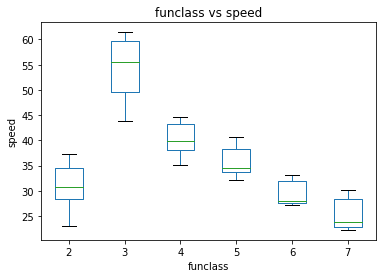

In [84]:
sp_fun_df['SPEED'].unstack(level=0).plot(kind='box', subplots=False)
#plt.title('每种类路段的全天时速分配')
plt.title('funclass vs speed')
plt.xlabel('funclass')
plt.ylabel('speed')
plt.show()
# 这个图表示 平均时速

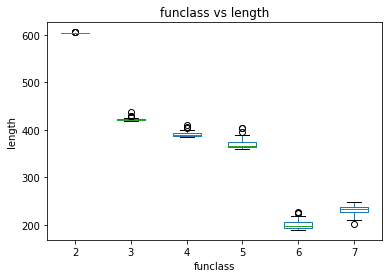

In [85]:
sp_fun_df['LEN'].unstack(level=0).plot(kind='box', subplots=False)
#plt.title('每种类路段的全天时速分配')
plt.title('funclass vs length')
plt.xlabel('funclass')
plt.ylabel('length')
plt.show()
# 这个图表示 长度 和 funclass 关系

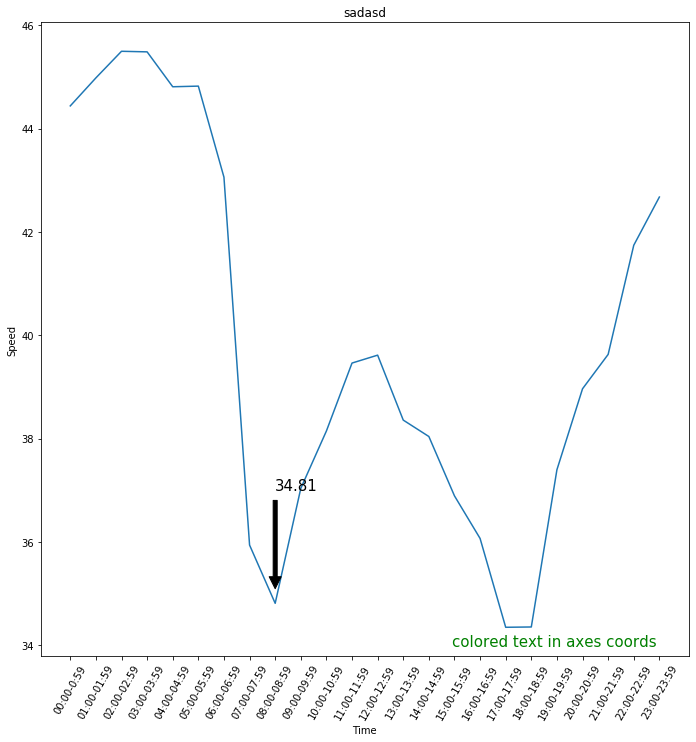

In [29]:
x1 = list(ch_df.index)
y1 = list(ch_df.SPEED)

fig, ax = plt.subplots(figsize=(10, 10)) # 控制图大小
fig.subplots_adjust(bottom=0, left=0)
ax.plot(x1, y1)
plt.xticks(rotation=60)
ax.annotate('34.81', fontsize = 15, xy=('08:00-08:59', 35), xytext=('08:00-08:59', 37),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.text(0.95, 0.01, 'colored text in axes coords',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='green', fontsize=15)

ax.set_xlabel('Time')
ax.set_ylabel('Speed')
plt.title('sadasd')
plt.show()

#这个图说明了高峰时间和平常时间的平均车速

In [30]:
g_len = data.groupby(['LEN']).count()
g_len.head()

,FUNCLASS,UPDATE_TIME,SPEED
LEN,,,
1.187399,1409,1409,1409
2.856190,808,808,808
3.808256,826,826,826
3.832922,837,837,837
4.411950,548,548,548


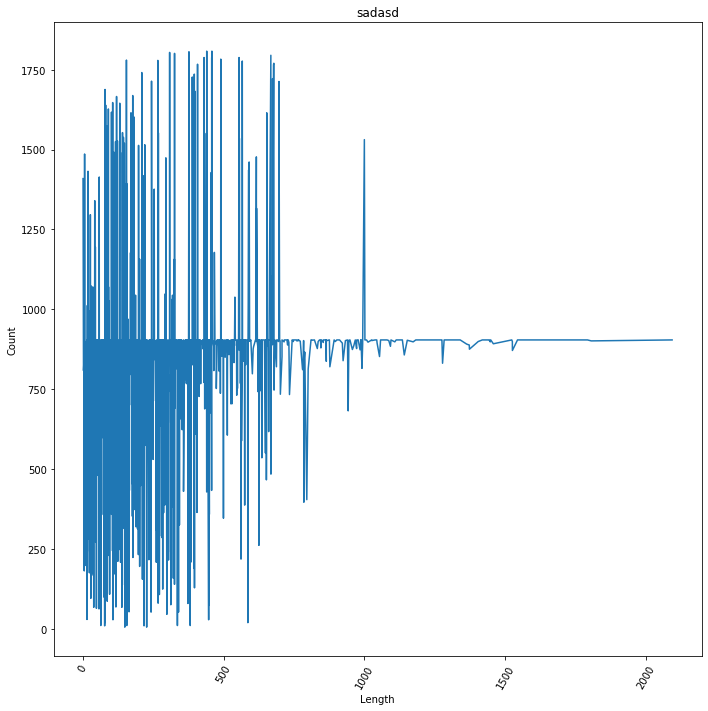

In [32]:
x1 = list(g_len.index)
y1 = list(g_len.SPEED)

fig, ax = plt.subplots(figsize=(10, 10)) # 控制图大小
fig.subplots_adjust(bottom=0, left=0)
ax.plot(x1, y1)
plt.xticks(rotation=60)

ax.set_xlabel('Length')
ax.set_ylabel('Count') # 数量
plt.title('sadasd')
plt.show()

In [33]:
g_len2 = data.groupby(['FUNCLASS']).mean()
g_len2

,LEN,SPEED
FUNCLASS,,
2,604.473350,30.904027
3,422.739277,53.898201
4,391.449613,40.031394
5,371.571784,35.308665
6,200.616861,28.960920
7,231.473754,24.967931


In [36]:
g_len2['time'] = g_len2.LEN/g_len2.SPEED/1000*3600
g_len2.head()

,LEN,SPEED,time
FUNCLASS,,,
2,604.473350,30.904027,70.414902
3,422.739277,53.898201,28.235848
4,391.449613,40.031394,35.202837
5,371.571784,35.308665,37.884707
6,200.616861,28.960920,24.937768


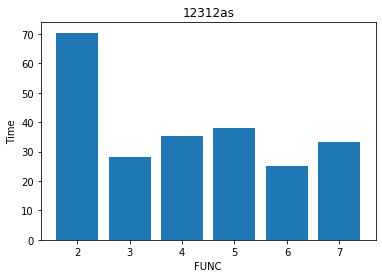

In [37]:
plt.bar(list(g_len2.index), list(g_len2.time)) #时间
plt.title('12312as')
plt.xlabel('FUNC')
plt.ylabel('Time')
plt.show() ## 通过每条路花费的平均时间